In [2]:
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

In [3]:
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [4]:
#2. Advandced Queries for Data Analysis

spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()


#TUGAS
#No 1 rata-rata gaji perdepartemen
spark.sql('''
SELECT DeptID, AVG(Salary) as avgSalary
FROM employees
GROUP BY DeptID
''').show()

#No 2 Karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing
spark.sql('''
WITH AvgSalaryByGender AS (
    SELECT Gender, AVG(Salary) as avgSalary
    FROM employees
    GROUP BY Gender
)
SELECT a.Name, a.Gender, a.Salary
FROM employees a
JOIN AvgSalaryByGender ags ON a.Gender = ags.Gender
WHERE a.Salary > ags.AvgSalary
''').show()

#No 3 ranking karyawan berdasarkan gaji dalam departemen mereka
spark.sql('''
SELECT Name, Salary, DeptID,
       RANK() OVER (PARTITION BY DeptID ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+

+------+---------+
|DeptID|avgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+

+-----+------+------+
| Name|Gender|Salary|
+-----+------+------+
|James|     M|  3000|
+-----+------+------+

+-----+------+------+----------+
| Name|Salary|DeptID|SalaryRank|
+-----+------+------+----------+
|James|  3000|     1|         1|
|  Lee|  2700|     1|         2|
| Anna|  4100|     2|         1|
+-----+------+------+----------+



In [7]:
#3. Penggunaan Window Function dan Subqueries

spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()


#Fungsi window untuk menemukan top 3 karyawan dalam kelompok usia tertentu.
from pyspark.sql import functions as F
from pyspark.sql.window import Window

windowSpec = Window.partitionBy('Age').orderBy(F.desc('Salary'))
# Menggunakan ROW_NUMBER() untuk memberi peringkat pada karyawan
ranked_df = df.withColumn('rank', F.row_number().over(windowSpec))
# Mengambil top 3 karyawan dari setiap kelompok usia
top_3_employees = ranked_df.filter(ranked_df.rank <= 3)
# Menampilkan hasil
top_3_employees.show()


+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+

+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|rank|
+-----+---+------+------+------+----+
|  Lee| 23|     M|  2700|     1|   1|
| Anna| 28|     F|  4100|     2|   1|
|James| 34|     M|  3000|     1|   1|
+-----+---+------+------+------+----+



In [12]:
#4. Advanced Spark SQL Queries
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Andrey', 23, 'M', 3100, 1),
    ('Selena', 34, 'F', 3700, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

#Query sql untuk menemukan rata-rata gaji per departemen dan ranking setiap karyawan dalam departemen berdasarkan gaji
spark.sql('''
SELECT Name, Age, Salary, DeptID,
       AVG(Salary) OVER (PARTITION BY DeptID) as AvgSalary,
       RANK() OVER (PARTITION BY DeptID ORDER BY Salary DESC) as SalaryRank
FROM employees
''').show()

#window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen

windowSpec = Window.partitionBy('DeptId', 'Age').orderBy('Salary')
# Menghitung gaji rata-rata berdasarkan kelompok umur di setiap departemen
salary_trend_df = employees.groupBy('DeptId', 'Age').agg(F.avg('Salary').alias('AvgSalary'))
# Menambahkan nomor urut untuk setiap kelompok umur dalam departemen
ranked_trend_df = salary_trend_df.withColumn('rank', F.row_number().over(Window.partitionBy('DeptId').orderBy('AvgSalary')))
# Menampilkan tren gaji berdasarkan usia di setiap departemen
ranked_trend_df.show()

+------+---+---------+-----------+
|  Name|Age| DeptName|ProjectName|
+------+---+---------+-----------+
|Andrey| 23|       HR|  Project A|
|   Lee| 23|       HR|  Project A|
| James| 34|       HR|  Project A|
|Selena| 34|Marketing|  Project B|
|  Anna| 28|Marketing|  Project B|
+------+---+---------+-----------+

+------+---+------+------+------------------+----------+
|  Name|Age|Salary|DeptID|         AvgSalary|SalaryRank|
+------+---+------+------+------------------+----------+
|Andrey| 23|  3100|     1|2933.3333333333335|         1|
| James| 34|  3000|     1|2933.3333333333335|         2|
|   Lee| 23|  2700|     1|2933.3333333333335|         3|
|  Anna| 28|  4100|     2|            3900.0|         1|
|Selena| 34|  3700|     2|            3900.0|         2|
+------+---+------+------+------------------+----------+

+------+---+---------+----+
|DeptId|Age|AvgSalary|rank|
+------+---+---------+----+
|     1| 23|   2900.0|   1|
|     1| 34|   3000.0|   2|
|     2| 34|   3700.0|   1|
| 

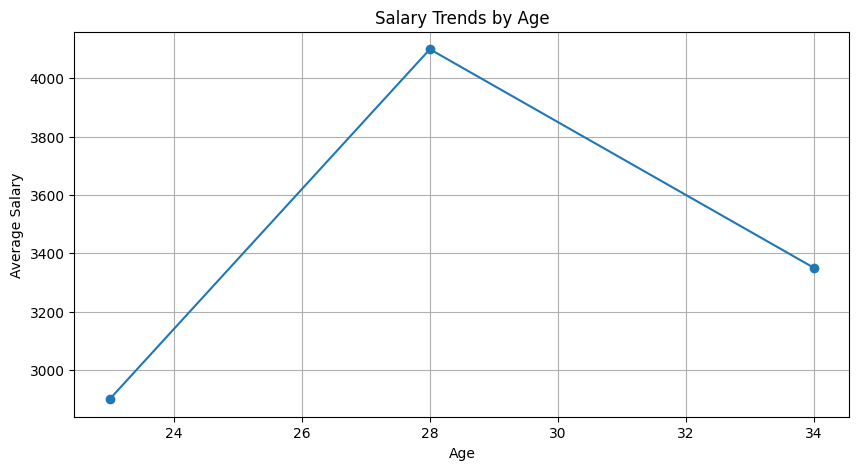

In [13]:
#5. Advanced Data Analysis and Visualization

import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


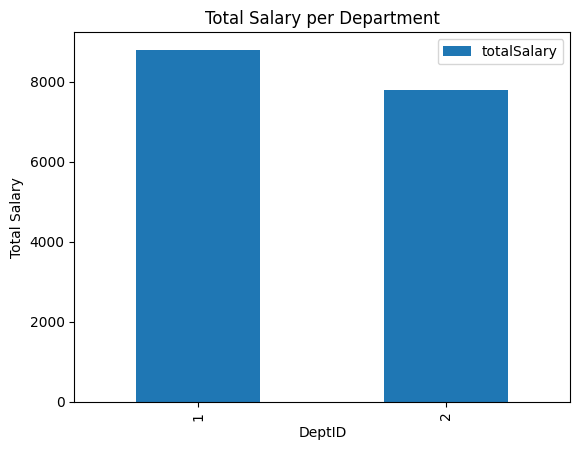

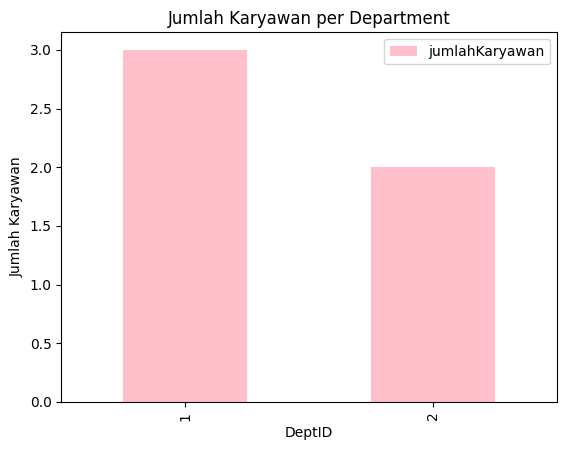

In [18]:
#6. HOMEWORK

#Tugas 1 : Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen
totalsalary_trends = spark.sql('''
SELECT DeptID, SUM(Salary) as totalSalary
FROM employees
GROUP BY DeptID
''').toPandas()

jmlhkaryawan_trends = spark.sql('''
SELECT DeptID, COUNT(*) as jumlahKaryawan
FROM employees
GROUP BY DeptID
''').toPandas()

totalsalary_trends.plot(x='DeptID', y='totalSalary', kind='bar')
plt.xlabel('DeptID')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')

jmlhkaryawan_trends.plot(x='DeptID', y='jumlahKaryawan', kind='bar', color='pink')
plt.xlabel('DeptID')
plt.ylabel('Jumlah Karyawan')
plt.title('Jumlah Karyawan per Department')
plt.show()



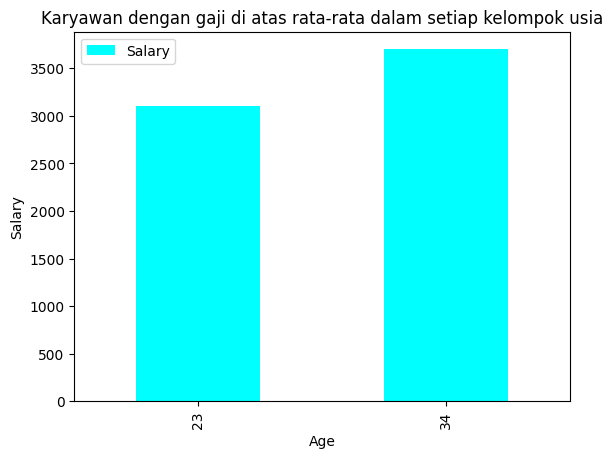

In [17]:
#Tugas 2 : Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
AboveAVGSalary = spark.sql('''
WITH avg_salary_per_age_group AS (
    SELECT Age, AVG(Salary) AS avgSalary
    FROM employees
    GROUP BY Age
)
SELECT e.Name, e.Age, e.Salary, a.avgSalary
FROM employees e
JOIN avg_salary_per_age_group a ON e.Age = a.Age
WHERE e.Salary > a.avgSalary
ORDER BY e.Age
''').toPandas()

AboveAVGSalary.plot(x='Age', y='Salary', kind='bar', color='cyan')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('Karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia')
plt.show()



In [19]:
from google.colab import files
uploaded = files.upload()


Saving TopScorers.csv to TopScorers.csv


+--------------+--------------------+-----+-----+
|        League|        Player_Names|Goals|Shots|
+--------------+--------------------+-----+-----+
|       La Liga|         Luis Suarez|   16|   79|
|       La Liga|       Karim Benzema|   21|  124|
|       La Liga|              Joselu|   11|   87|
|       La Liga|    Carlos Fernandez|   10|   47|
|       La Liga|        Ante Budimir|   13|   56|
|       La Liga|     Mikel Oyarzabal|   10|   62|
|       La Liga|        Willian Jose|   11|   59|
|       La Liga|       Gerard Moreno|   18|   89|
|       La Liga|         Lucas Perez|   11|   48|
|       La Liga|         Loren Moron|   10|   52|
|       La Liga|         Raul Garcla|   15|   81|
|       La Liga|             Morata |   12|   69|
|       La Liga|     Angel Rodriguez|   10|   53|
|       La Liga|        Lionel Messi|   25|  159|
|       La Liga|        Sergio Ramos|   11|   39|
|       La Liga|       Lucas Ocampos|   14|   84|
|       La Liga|            Cazorla |   11|   49|


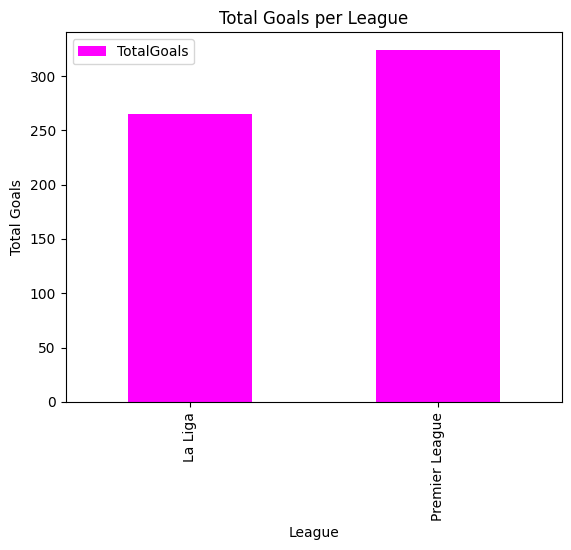

+--------------+--------+
|        League|avgGoals|
+--------------+--------+
|Premier League|    16.2|
|       La Liga|   13.25|
+--------------+--------+



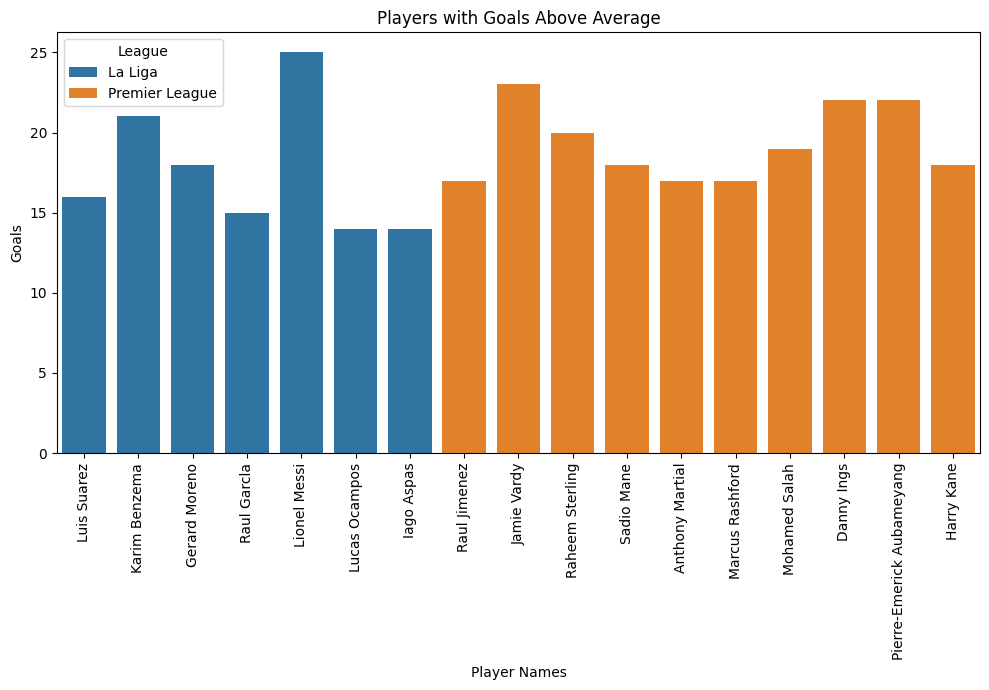

In [20]:
df = spark.read.csv('/content/TopScorers.csv', header=True, inferSchema=True)
df.show(40)

# Create a temporary view named 'TopScorers' from the DataFrame 'df'
df.createOrReplaceTempView("TopScorers")

PerLiga = spark.sql('''
SELECT League, SUM(Goals) AS TotalGoals, COUNT(Player_Names) AS TotalPlayers
FROM TopScorers
GROUP BY League
ORDER BY League
''').toPandas()

PerLiga.plot(x='League', y='TotalGoals', kind='bar', color='magenta')
plt.xlabel('League')
plt.ylabel('Total Goals')
plt.title('Total Goals per League')
plt.show()

spark.sql('''
SELECT League, AVG(Goals) AS avgGoals
FROM TopScorers
GROUP BY League
''').show()

GoalsAboveAVG = spark.sql('''
WITH avgGoals AS (
    SELECT League, AVG(Goals) AS avgGoals
    FROM TopScorers
    GROUP BY League
)
SELECT f.League, f.Player_Names, f.Goals
FROM TopScorers f
JOIN avgGoals ags ON f.League = ags.League
WHERE f.Goals > ags.avgGoals
ORDER BY f.League
''').toPandas()

import seaborn as sns
plt.figure(figsize=(10, 7))

sns.barplot(x='Player_Names', y='Goals', hue='League', data=GoalsAboveAVG)

plt.xlabel('Player Names')
plt.ylabel('Goals')
plt.title('Players with Goals Above Average')
plt.xticks(rotation=90)
plt.legend(title='League')
plt.tight_layout()
plt.show()

